In [128]:
import ee
import geemap
import os
from datetime import datetime, timedelta
import numpy as np
import geopandas as gpd
import pandas as pd
import math
import matplotlib.pyplot as plt
import geemap
import plotnine as p9

In [108]:
ee.Initialize()

In [323]:
def get_ee_pixel_poly(coords_xy, ic_str, band_name, buffer_m = 0, vector_type = 'ee'):

    pt = ee.Geometry.Point(coords_xy)
    
    ic = ee.ImageCollection(ic_str)
    ic_im = ic.filterBounds(pt).first().select(band_name)
    # oli8_px_int = oli8_px.select('SR_B5').gt(25000).rename('test')
    px_poly = ic_im.reduceToVectors(
        geometry = pt.buffer(buffer_m),
        scale = ic_im.projection().nominalScale())
    
    if vector_type == 'ee':
        # do nothing -- good to go
        pass
    elif vector_type == 'gpd':
        px_poly = geemap.ee_to_geopandas(px_poly).set_crs(epsg=4326)
    else:
        raise Exception("vector_type must be ee_fc or gpd")
        
    return px_poly

In [140]:
ic_str = "LANDSAT/LC08/C02/T1_L2"
coords_xy = [104.9995, 20.0005]
landsat_grid_poly = get_ee_pixel_poly(coords_xy, ic_str, 'SR_B5', buffer_m = 60, vector_type = 'gpd')
s2_grid_poly = get_ee_pixel_poly(coords_xy, 'COPERNICUS/S2', 'B4', buffer_m = 60, vector_type = 'gpd')
# s2_harm_px = get_ee_pixel_poly(coords_xy, 'COPERNICUS/S2_HARMONIZED', 'B4', buffer_m = 60, vector_type = 'gpd')

In [299]:
pt_xy = gpd.points_from_xy([coords_xy[0]], [coords_xy[1]], crs = 'epsg:4326')
pt_xy_gpd = gpd.GeoSeries(pt_xy)

# lpx_poly = landsat_grid_poly[5:6]

# get only the pixel polygons containing the point
landsat_px_poly = [landsat_grid_poly.loc[i:i] for i in landsat_grid_poly.index if pt_xy_gpd.within(landsat_grid_poly.loc[i,'geometry'])[0]][0]
s2_px_poly = [s2_grid_poly.loc[i:i] for i in s2_grid_poly.index if pt_xy_gpd.within(s2_grid_poly.loc[i,'geometry'])[0]][0]
# gpd.GeoSeries(pt_xy).within(landsat_grid_poly)
# pt_xy_gpd.within(landsat_grid_poly.loc[5,'geometry'])[0]

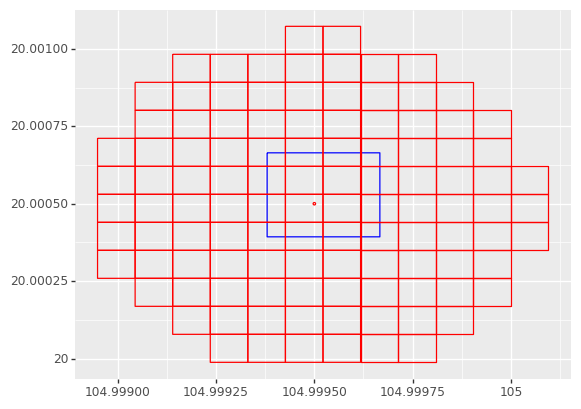

<ggplot: (673887964)>

In [190]:
(p9.ggplot() + 
  p9.geom_map(data = landsat_grid_poly.iloc[5:6], color = 'blue', fill = None) + 
  p9.geom_map(data = s2_grid_poly, color = 'red', fill = None) +
  p9.geom_map(data = gpd.GeoDataFrame(geometry=gpd.GeoSeries(pt_xy)), color = 'red', fill = None))# +
  # p9.annotate(geom = 'point', x = coords_xy[0],y = coords_xy[1]))
# landsat_pt.intersects(

In [301]:
import folium
loc_pt_latlon = coords
m_folium = folium.Map(location = [20.0005, 104.9995], zoom_start = 18)
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
        ).add_to(m_folium)

def style(color = 'blue'):
    def dummy_func(feature):
        return {
            'fill': False,
            'color': color,
            'weight': 1
        }
    return(dummy_func)
    
folium.GeoJson(data = landsat_px_poly, 
               style_function = style('red')).add_to(m_folium)
folium.GeoJson(data = s2_px_poly, 
               style_function = style()).add_to(m_folium)

In [61]:
# s2_harm_px.crs
s2_px.first().geometry().projection().crs().getInfo()

'EPSG:4326'

In [41]:
type(geemap.ee_to_geopandas(s2_harm_px))

geopandas.geodataframe.GeoDataFrame

In [4]:
# oli8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
# reducervector = pt.buffer(100)
# oli8_px = oli8.filterBounds(pt).first().clip(reducervector)
# oli8_px_int = oli8_px.select('SR_B5').gt(25000).rename('test')
# oli8_shp = oli8_px_int.reduceToVectors(
#     geometry = pt,
#     scale = 30)


In [324]:
ee_pt = ee.Geometry.Point(coords_xy)
s2 = ee.ImageCollection('COPERNICUS/S2')
# s2.first().select('B4').projection().nominalScale().divide(10).getInfo()
s2_im = s2.filterBounds(pt).first()

s2_ee_poly = get_ee_pixel_poly(coords_xy, 'COPERNICUS/S2', 'B4', buffer_m = 60, vector_type = 'ee')


In [322]:
s2.first().select('B4').projection().nominalScale().divide(10).getInfo()


1

In [307]:
s2_im

In [7]:
Map = geemap.Map()

In [325]:
# Map.addLayer(oli8_px_int,{'bands':['test']},'oli8_px_shp')
Map.addLayer(s2_im,{'bands':['B8','B4','B3'],'min':4000, 'max':5000},'s2_im')

# Map.addLayer(pt,{'color': 'red'},'pt')
# Map.addLayer(landsat_pt,{'color': 'blue'},'landsat_pt')
Map.addLayer(ee.Image().paint(s2_ee_poly,1,1),{'palette': 'blue'},'s2_px')
# Map.addLayer(s2_harm_px,{'color?': 'green'},'s2_harm_px')
Map.centerObject(pt, 18)
Map.addLayerControl()

In [9]:
Map

Map(center=[20.0005, 104.9995], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

In [302]:
m_folium

In [76]:
s2_harm_px = s2_harm_px.set_crs(epsg=4326)
s2_harm_px

,geometry,count,label
0,"POLYGON ((104.99943 20.00053, 104.99943 20.000...",1,3950


In [196]:
# landsat_grid_poly.iloc[1:2]

# landsat_grid_poly.iloc[6:7].intersects(gpd.GeoSeries(pt_xy))
landsat_grid_poly.ix[0]

AttributeError: 'GeoDataFrame' object has no attribute 'ix'

In [214]:
import geopandas
from shapely.geometry import Polygon, Point

p1 = Point(.5,.5)
p2 = Point(.5,1)
p3 = Point(1,1)

points = GeoSeries([p1,p2,p3])

poly = GeoSeries([Polygon([(0,0), (0,2), (2,2), (2,0)])])

# geopandas.overlay(points, poly, how='intersection')

In [203]:
gpd.__version__

'0.11.1'

In [215]:
g1 = gpd.GeoSeries([p1,p2,p3])
g2 = gpd.GeoSeries([p2,p3])

g = gpd.GeoSeries([Polygon([(0,0), (0,2), (2,2), (2,0)])])

g1.intersects(g) # Flags the first point as inside, even though all are.
# g2.intersects(g) # The second point gets picked up as inside (but not 3rd)

0     True
1    False
2    False
dtype: bool

In [298]:
landsat_px_poly[0].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich